In [3]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Постройте графики зависимости сходимости (значение функции потерь от количества итераций работы алгоритма)
# от выбора оптимизационного метода
# количество эпох = 50
# Сравните, сделайте выводы
# https://pytorch.org/docs/stable/optim.html

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

learning_rate = 0.001
epochs = 50
batch = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
NVIDIA GeForce RTX 3050 Laptop GPU


In [5]:

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(training_data, batch_size=batch)
test_dataloader = DataLoader(test_data, batch_size=batch)


loss_fn = nn.CrossEntropyLoss()

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)

    sum_loss = 0
    model.train() 
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Вычисляем предсказание и потерю
        pred = model(X)
        loss = loss_fn(pred, y)
        sum_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss_value = loss.item()
            current = batch * dataloader.batch_size + len(X)
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")

    return sum_loss / len(dataloader)

In [8]:
def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct, test_loss

In [9]:
def run_training(epochs, train_dataloader, model, loss_fn, optimizer):
    test_loss = []
    train_loss = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        sum_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        train_loss.append(sum_loss)

        acc, avg_loss = test_loop(test_dataloader, model, loss_fn)
        test_loss.append(avg_loss)
    print("Done!")

    return train_loss, test_loss

In [10]:
optimizers = {
    "SGD": torch.optim.SGD,
    "Adam": torch.optim.Adam,
    "RMSprop": torch.optim.RMSprop,
    "Adagrad": torch.optim.Adagrad
}

results = {}

for name, optimizer_class in optimizers.items():
    model = NeuralNetwork().to(device)
    optimizer = optimizer_class(model.parameters(), lr=learning_rate)
    
    train_loss, test_loss = run_training(epochs, train_dataloader, model, loss_fn, optimizer)
    results[name] = train_loss, test_loss

Epoch 1
-------------------------------
loss: 2.303109  [   64/60000]
loss: 2.294997  [ 6464/60000]
loss: 2.283823  [12864/60000]
loss: 2.279265  [19264/60000]
loss: 2.254798  [25664/60000]
loss: 2.238134  [32064/60000]
loss: 2.233265  [38464/60000]
loss: 2.206318  [44864/60000]
loss: 2.205281  [51264/60000]
loss: 2.170550  [57664/60000]
Test Error: 
 Accuracy: 49.8%, Avg loss: 2.171488 

Epoch 2
-------------------------------
loss: 2.179189  [   64/60000]
loss: 2.172055  [ 6464/60000]
loss: 2.125732  [12864/60000]
loss: 2.135398  [19264/60000]
loss: 2.091167  [25664/60000]
loss: 2.045823  [32064/60000]
loss: 2.051126  [38464/60000]
loss: 1.985498  [44864/60000]
loss: 1.986662  [51264/60000]
loss: 1.911265  [57664/60000]
Test Error: 
 Accuracy: 57.4%, Avg loss: 1.916073 

Epoch 3
-------------------------------
loss: 1.948401  [   64/60000]
loss: 1.917244  [ 6464/60000]
loss: 1.815062  [12864/60000]
loss: 1.839658  [19264/60000]
loss: 1.751102  [25664/60000]
loss: 1.701475  [32064/600

In [11]:
def print_plot(results, kind):
    kind_dict = {
        'train': 0,
        'test': 1
    }
    plt.figure(figsize=(10, 6))
    for name, losses in results.items():
        plt.plot(range(1, epochs + 1), losses[kind_dict[kind]], label=name)

    plt.title(f'{kind.capitalize()} Loss Comparison for Different Optimizers')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

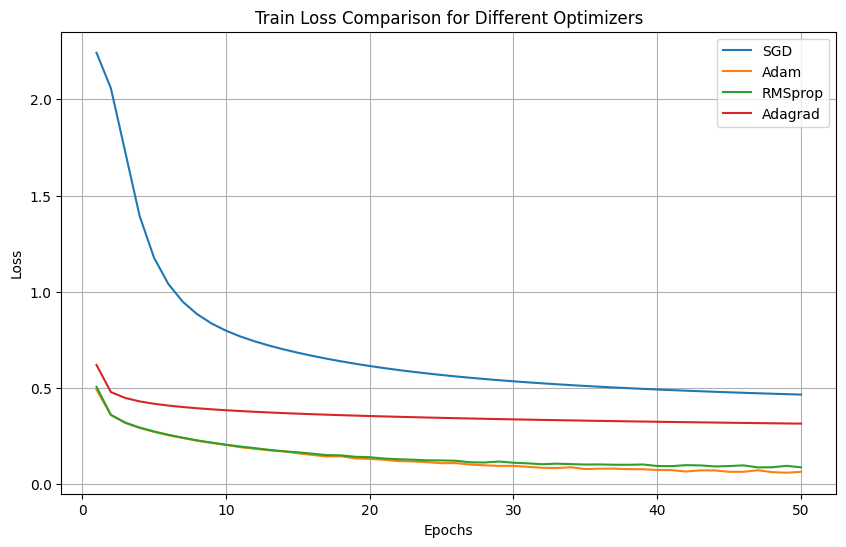

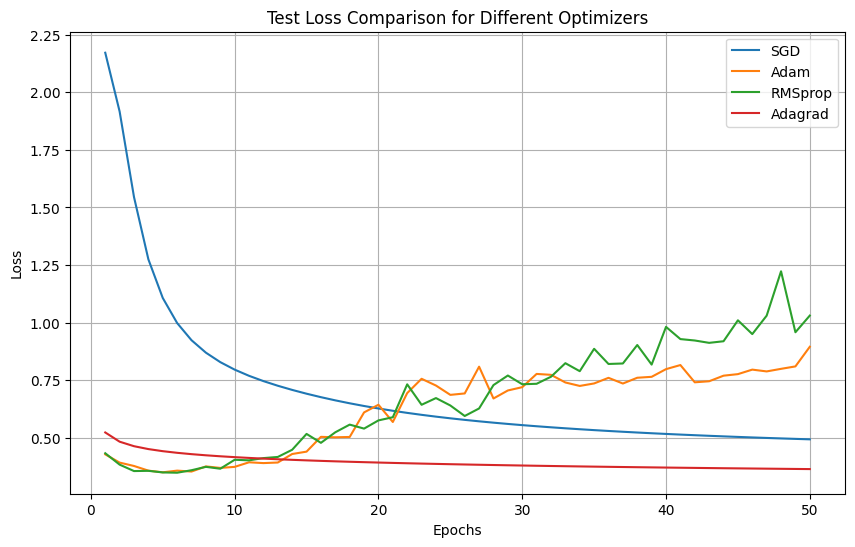

In [12]:
print_plot(results, 'train')
print_plot(results, 'test')

### Выводы

- **SGD** 

     Показывает стабильную сходимость на тренировочных и тестовых данных. Для улучшения результатов следует повысить количество эпох
- **Adam**
- **RMSProp**

     Быстрее остальных сходятся на тренировочных данных, но могут переобучиться. Для улучшения результатов следует уменьшить количество эпох
- **Adagrad**

     На поздних этапах перестаёт обучаться, хотя на начальных этапах показывает достойные результаты. При увеличении эпох _SGD_ обойдёт _Adagrad_.
     >Стоит увеличить начальный коэф скорости обучения??